In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm_notebook
from IPython.display import clear_output
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as tdata

In [3]:
def plot_acoustic_ttf(data):
    fig, ax1 = plt.subplots()
    ax1.plot(range(len(data)), data['acoustic_data'], label='acoustic_data')

    ax2 = ax1.twinx()
    ax2.plot(range(len(data)), data['time_to_failure'], label='ttf')

    ax1.legend()
    ax2.legend()

    plt.show()

In [4]:
def add_datetime_index(data):
    times = [datetime(2019,1,2) -  timedelta(microseconds=ttf*1_000_000) for ttf in data['time_to_failure']]
    data.index = pd.Series(range(len(times)), times).index
def resample(df, n):
    s = (df.index.to_series() / n).astype(int)
    return df.groupby(s).mean()#.set_index(s.index[0::n])

In [5]:
DOWNSAMPLING = 64

In [7]:
train = []
for chunk in tqdm_notebook(pd.read_csv('train.csv',
                        dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32},
                        chunksize=DOWNSAMPLING*100_000)):
    train.append(resample(chunk, DOWNSAMPLING))
train = pd.concat(train, ignore_index=True)

In [7]:
# train = pd.read_csv('train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [8]:
train.head()

,acoustic_data,time_to_failure
0,5.296875,1.4691
1,5.234375,1.4691
2,5.218750,1.4691
3,4.937500,1.4691
4,5.109375,1.4691


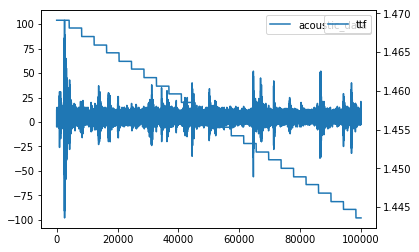

In [6]:
train100k = train.head(100000)
plot_acoustic_ttf(train100k)

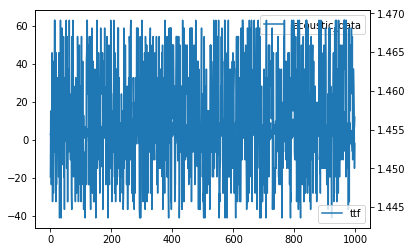

In [7]:
plot_acoustic_ttf(train100k.sample(frac=0.01))

In [8]:
train100k.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [9]:
train15m = train.head(15_000_000)
# train15m_r = resample(train15m, 64)

In [11]:
resample(train100k, 4096).head()

,acoustic_data,time_to_failure
0,5.191650,1.469097
1,5.201416,1.468097
2,4.970947,1.466998
3,4.956543,1.465897
4,4.869141,1.464898


In [12]:
# Sample rate based on https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/77526#458580
plot_acoustic_ttf(train1m.resample('0.001064S').mean())

NameError: name 'train1m' is not defined

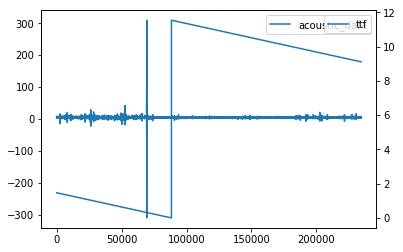

In [11]:
plot_acoustic_ttf(train15m_r)

In [7]:
train_r = resample(train, 64)

MemoryError: 

In [10]:
INPUT_SIZE = 1024
BATCH_SIZE = 1024

In [11]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 100)
#         self.bn1 = nn.BatchNorm1d(100)
        self.fc2 = nn.Linear(100, 10)
#         self.bn2 = nn.BatchNorm1d(10)
        self.fc3 = nn.Linear(10, 1)
        
    def forward(self, x):
#         x = F.relu(self.bn1(self.fc1(x)))
#         x = F.relu(self.bn2(self.fc2(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [12]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.c1 = nn.Conv1d(1, 32, 4)
        self.bn1 = nn.BatchNorm1d(32)
        self.c2 = nn.Conv1d(32, 64, 4, 2)
        self.bn2 = nn.BatchNorm1d(64)
        self.c3 = nn.Conv1d(64, 128, 4, 2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool = nn.AvgPool1d(253)
        self.do = nn.Dropout()
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.c1(x)))
#         print("1:", x.shape)
        x = F.relu(self.bn2(self.c2(x)))
#         print("2:", x.shape)
        x = F.relu(self.bn3(self.c3(x)))
#         print("3:", x.shape)
        x = self.pool(x)
#         print("4:", x.shape)
        x = self.do(x.view(-1, 128))
#         print("5:", x.shape)
        return self.fc1(x)

In [13]:
net = SimpleNet()
# del net
torch.cuda.empty_cache()

# net = ConvNet()
net = net.cuda()

In [18]:
train15m_r.values.T[1].shape[0]

234375

In [14]:
class LanlDataset(tdata.Dataset):
    def __init__(self, data, chunksize):
        super(LanlDataset, self).__init__()
        data_x, data_y = data.values.T
        self.x = torch.tensor(data_x, dtype=torch.float)
        self.y = torch.tensor(data_y, dtype=torch.float)
        self.chunksize = chunksize
    
    def __len__(self):
        return self.x.shape[0] - (self.chunksize - 1)
    
    def __getitem__(self, i):
        xs = self.x[i:i+self.chunksize]
        ys = self.y[i:i+self.chunksize]
        return xs, ys

In [15]:
dataset = LanlDataset(train, INPUT_SIZE)

In [16]:
loader = tdata.DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)

In [66]:
for i, data in enumerate(loader):
    labels, targets = data
    print(labels.shape)
    print(targets.shape)
    print(labels[0:5])
    print(targets[0:5])
    break

torch.Size([1024, 1024])
torch.Size([1024, 1024])
tensor([[5.0625, 6.0469, 4.9375,  ..., 5.4688, 5.2656, 5.7344],
        [3.4375, 3.2031, 3.3594,  ..., 4.2969, 4.8594, 3.6406],
        [3.5625, 7.1719, 2.8750,  ..., 4.5781, 4.4531, 5.2344],
        [5.2969, 4.3125, 4.8125,  ..., 4.7031, 4.7969, 4.6719],
        [4.3438, 3.7344, 4.2344,  ..., 4.0156, 4.1094, 4.1094]])
tensor([[ 6.2494,  6.2494,  6.2494,  ...,  6.2324,  6.2324,  6.2324],
        [ 5.1004,  5.1004,  5.1004,  ...,  5.0834,  5.0834,  5.0834],
        [12.2356, 12.2356, 12.2356,  ..., 12.2186, 12.2186, 12.2186],
        [ 2.6608,  2.6608,  2.6608,  ...,  2.6437,  2.6437,  2.6437],
        [ 0.9188,  0.9188,  0.9188,  ...,  0.9018,  0.9018,  0.9018]])


Epoch 0



Epoch 1



Epoch 2


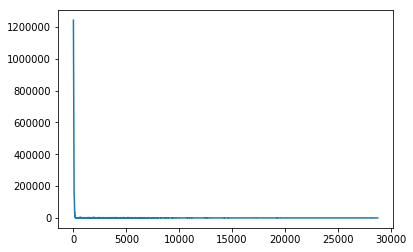

In [18]:
net.train()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-6)
loss_fn = nn.MSELoss()
losses = []
for epoch in range(3):
    print("Epoch", epoch)
    for i, data in enumerate(tqdm_notebook(loader)):
        optimizer.zero_grad()
        
        labels, targets = data
        labels = labels.cuda()

        if isinstance(net, ConvNet):
            labels = labels.view(-1, 1, INPUT_SIZE)

        pred = net(labels)
        
        loss = loss_fn(pred, targets[-1].cuda())
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        del labels
        del targets

torch.cuda.empty_cache()

plt.plot(losses)
plt.show()

In [25]:
torch.save(net.state_dict(), 'simple.sd')

In [17]:
net.load_state_dict(torch.load('simple.sd'))

RuntimeError: Error(s) in loading state_dict for SimpleNet:
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "bn2.num_batches_tracked". 

In [23]:
def plot_acoustic_ttf_prediction(data, model):
    batch_size = 128
    model.eval()
    predictions = []
    input_batches = []

    try:
        for i in tqdm_notebook(range(INPUT_SIZE+(batch_size-1), len(data), batch_size)):
            chunk = data[i-INPUT_SIZE-(batch_size-1):i]
            tensor = torch.tensor(chunk['acoustic_data'].values,
                                  dtype=torch.float).unfold(0, INPUT_SIZE, 1)
            input_batches.append(tensor)

#         tensor = torch.tensor(data['acoustic_data'].values, dtype=torch.float) \
#             .unfold(0, INPUT_SIZE, 1)
#         n_full_windows = tensor.shape[0] // BATCH_SIZE


#         input_batches = tensor[0:n_full_windows*BATCH_SIZE, :].view(-1, BATCH_SIZE, INPUT_SIZE)
        for input_batch in tqdm_notebook(input_batches[:10000]):
#             print(input_batch.shape)
#             break
#             pass
            input_batch_cuda = input_batch.cuda()
            predictions.extend(model(input_batch_cuda).cpu())
            del input_batch_cuda
#             torch.cuda.empty_cache()
    
#         predictions = [x for input_batch in tensor for x in model(input_batch.cuda())]
    except RuntimeError as e:
        print(e)
        del tensor
        torch.cuda.empty_cache()
        raise e
    
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10,8)
    ax1.plot(range(len(data)), data['acoustic_data'], label='acoustic_data')

    ax2 = ax1.twinx()
    ax2.plot(range(len(data)), data['time_to_failure'], label='ttf')
    ax2.plot(range(INPUT_SIZE, INPUT_SIZE+len(predictions)), predictions, label='predictions')

    ax1.legend()
    ax2.legend()

    plt.show()

In [24]:
plot_acoustic_ttf_prediction(train15m, net)


CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 3.94 GiB total capacity; 3.36 GiB already allocated; 7.50 MiB free; 2.53 MiB cached)


RuntimeError: CUDA out of memory. Tried to allocate 1024.00 KiB (GPU 0; 3.94 GiB total capacity; 3.36 GiB already allocated; 7.50 MiB free; 2.53 MiB cached)

In [83]:
t = torch.tensor(train15m_r['acoustic_data'].values[0:12], dtype=torch.float).unfold(0, 3, 1).shape
t

torch.Size([10, 3])

In [31]:
m = nn.Conv1d(1, 32, 4)
t = torch.randn(20, 16, 50)
print(t)
m(t)

tensor([[[-0.6376,  0.2255,  0.0251,  ...,  0.5910,  0.4575,  0.4343],
         [-0.5749, -0.1897, -0.3647,  ..., -1.1582, -0.9481,  0.5997],
         [-0.1892, -0.1400,  1.0742,  ..., -1.4304,  2.1065,  1.3228],
         ...,
         [-0.7767, -0.6934, -0.2011,  ..., -1.3181,  0.1820, -1.2461],
         [-0.6786, -1.0768, -1.6570,  ..., -1.6149, -0.5205,  1.9812],
         [ 1.9821, -1.1426, -0.0954,  ...,  0.1358,  0.2461, -0.1152]],

        [[ 0.6999,  0.1536,  0.7456,  ..., -0.7882,  0.1610, -0.0583],
         [-1.1229, -0.6159, -1.8351,  ..., -1.8699, -0.1330, -0.4050],
         [-0.5799, -0.8027, -0.1388,  ...,  0.2183, -0.9707,  0.8275],
         ...,
         [ 1.4858,  1.0064,  0.8173,  ...,  2.4150,  1.0907,  0.3220],
         [-0.4668,  1.8441,  0.7587,  ...,  0.8976, -0.7716,  1.1935],
         [ 1.4420, -0.3438,  0.3710,  ..., -0.6587, -1.1251,  2.0182]],

        [[-1.1287,  0.7970, -0.2121,  ..., -0.3415,  1.9204, -1.9876],
         [-0.4087,  0.9478, -0.1549,  ..., -0

RuntimeError: Given groups=1, weight of size [32, 1, 4], expected input[20, 16, 50] to have 1 channels, but got 16 channels instead

In [75]:
torch.cuda.empty_cache()

In [42]:
d = torch.tensor([i for i in range(100)])
print(d.unfold(0,6,1)[:8])
d[20-6-(8-1):20].unfold(0, 6, 1)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 1,  2,  3,  4,  5,  6],
        [ 2,  3,  4,  5,  6,  7],
        [ 3,  4,  5,  6,  7,  8],
        [ 4,  5,  6,  7,  8,  9],
        [ 5,  6,  7,  8,  9, 10],
        [ 6,  7,  8,  9, 10, 11],
        [ 7,  8,  9, 10, 11, 12]])


tensor([[ 7,  8,  9, 10, 11, 12],
        [ 8,  9, 10, 11, 12, 13],
        [ 9, 10, 11, 12, 13, 14],
        [10, 11, 12, 13, 14, 15],
        [11, 12, 13, 14, 15, 16],
        [12, 13, 14, 15, 16, 17],
        [13, 14, 15, 16, 17, 18],
        [14, 15, 16, 17, 18, 19]])

In [19]:
del labels